In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline

#new models, more powerful?
import xgboost as xgb
import lightgbm as lgb

# Suppress warnings
warnings.filterwarnings("ignore")

# Import SMOTE for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("SMOTE not available. To install it, run: pip install imblearn") #I kept forgetting to install it

In [16]:
df = pd.read_csv('..\\..\\data\\csv\\FY_2022-2025.csv')
# Clean
df.columns = df.columns.str.strip()

In [17]:
def run_enhanced_model_pipeline(df, condition_name):
    """
    This function runs an enhanced modeling pipeline for a given condition,
    including advanced models, feature scaling, and comprehensive hyperparameter tuning.
    """
    print(f"\n--- Starting Enhanced Modeling Pipeline for {condition_name} ---")

    target_col = f'Penalty indicator for {condition_name}'
    err_col = f'ERR for {condition_name}'
    median_err_col = f'Peer group median ERR for {condition_name}'
    
    df_condition = df.copy()

    # Data Cleaning and Preparation
    df_condition.dropna(subset=[target_col, err_col, median_err_col], inplace=True)
    df_condition[target_col] = df_condition[target_col].apply(lambda x: 1 if x == 'Y' else 0)

    # Feature Engineering
    base_features = [
        'Payment adjustment factor', 'Payment reduction percentage', 'Dual proportion',
        'Peer group assignment', 'Neutrality modifier', err_col, median_err_col
    ]
    
    for col in base_features:
        df_condition[col] = pd.to_numeric(df_condition[col], errors='coerce')
        df_condition[col].fillna(df_condition[col].median(), inplace=True)

    df_condition['ERR_vs_median'] = df_condition[err_col] - df_condition[median_err_col]
    df_condition['ERR_ratio'] = df_condition[err_col] / df_condition[median_err_col]

    final_features = [
        'Payment adjustment factor', 'Payment reduction percentage', 'Dual proportion',
        'Peer group assignment', 'Neutrality modifier', 'ERR_vs_median', 'ERR_ratio'
    ]
    
    X = df_condition[final_features]
    y = df_condition[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # SMOTE for Imbalanced Data
    if SMOTE_AVAILABLE:
        print("\nApplying SMOTE to balance the training data...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    print("\n--- Starting Model Training and Tuning ---")
    # models, now including XGBoost and LightGBM
    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'GradientBoosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'LightGBM': lgb.LGBMClassifier(random_state=42)
    }

    #expanded hyperparameter grids for more thorough tuning
    param_grid = {
        'RandomForest': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [10, 20, None],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'GradientBoosting': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7]
        },
        'XGBoost': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7]
        },
        'LightGBM': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__num_leaves': [20, 31, 40]
        }
    }

    for model_name, model in models.items():
        print(f"\n--- Tuning and Evaluating {model_name} for {condition_name} ---")
        
        # Create a pipeline with scaling and the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Use StratifiedKFold for more robust cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid[model_name],
                                   cv=cv, n_jobs=-1, scoring='roc_auc', verbose=1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        
        best_model = grid_search.best_estimator_
        print(f"Best Parameters found: {grid_search.best_params_}")
        print(f"Best ROC AUC Score: {grid_search.best_score_:.4f}")

        # Final Evaluation on the Test Set
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        print(f"\n--- Final Evaluation for Tuned {model_name} ---")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['No Penalty', 'Penalty']))
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
                    xticklabels=['No Penalty', 'Penalty'], yticklabels=['No Penalty', 'Penalty'])
        plt.title(f'Enhanced Confusion Matrix for {model_name} ({condition_name})')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


--- Starting Enhanced Modeling Pipeline for HF ---

Applying SMOTE to balance the training data...

--- Starting Model Training and Tuning ---

--- Tuning and Evaluating RandomForest for HF ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters found: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__n_estimators': 300}
Best ROC AUC Score: 0.9967

--- Final Evaluation for Tuned RandomForest ---
Accuracy: 0.9866
ROC AUC Score: 0.9960

Classification Report:
              precision    recall  f1-score   support

  No Penalty       1.00      0.98      0.99      1492
     Penalty       0.97      1.00      0.99      1187

    accuracy                           0.99      2679
   macro avg       0.99      0.99      0.99      2679
weighted avg       0.99      0.99      0.99      2679



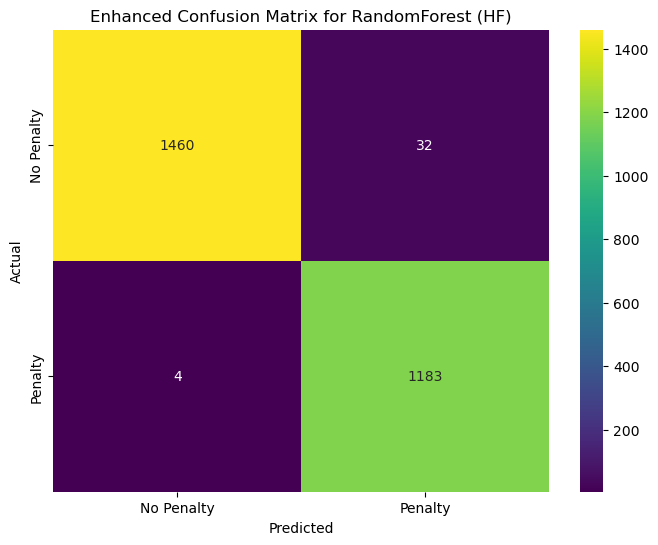


--- Tuning and Evaluating GradientBoosting for HF ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters found: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200}
Best ROC AUC Score: 0.9964

--- Final Evaluation for Tuned GradientBoosting ---
Accuracy: 0.9858
ROC AUC Score: 0.9954

Classification Report:
              precision    recall  f1-score   support

  No Penalty       1.00      0.98      0.99      1492
     Penalty       0.97      1.00      0.98      1187

    accuracy                           0.99      2679
   macro avg       0.98      0.99      0.99      2679
weighted avg       0.99      0.99      0.99      2679



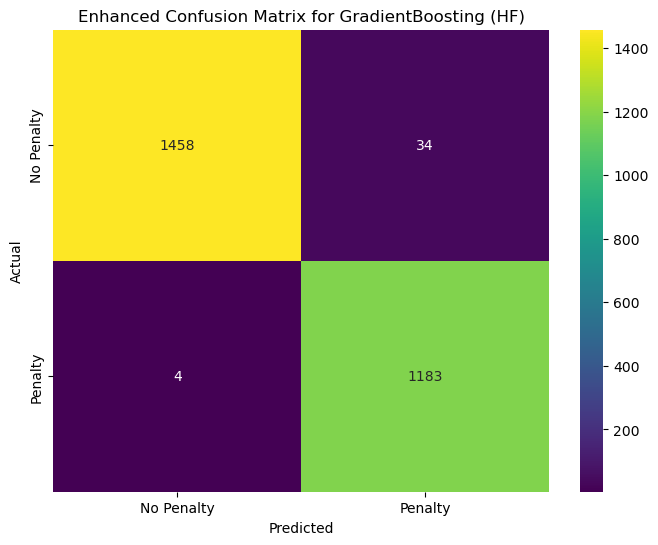


--- Tuning and Evaluating XGBoost for HF ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters found: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 100}
Best ROC AUC Score: 0.9965

--- Final Evaluation for Tuned XGBoost ---
Accuracy: 0.9854
ROC AUC Score: 0.9959

Classification Report:
              precision    recall  f1-score   support

  No Penalty       1.00      0.98      0.99      1492
     Penalty       0.97      1.00      0.98      1187

    accuracy                           0.99      2679
   macro avg       0.98      0.99      0.99      2679
weighted avg       0.99      0.99      0.99      2679



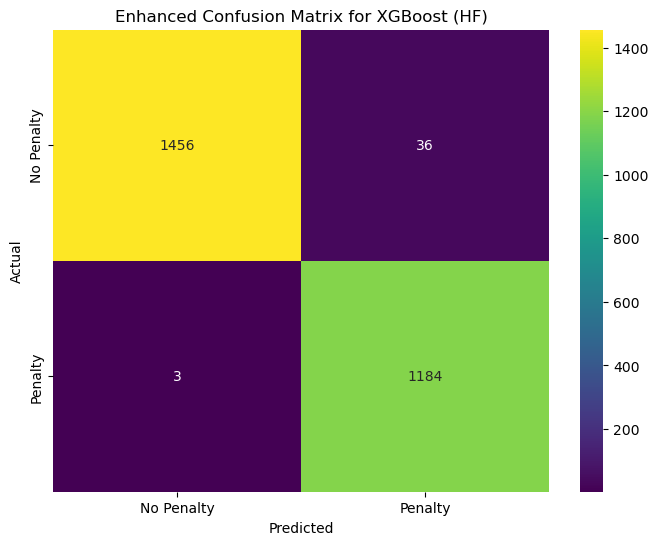


--- Tuning and Evaluating LightGBM for HF ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 3481, number of negative: 3481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1399
[LightGBM] [Info] Number of data points in the train set: 6962, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters found: {'model__learning_rate': 0.05, 'model__n_estimators': 200, 'model__num_leaves': 40}
Best ROC AUC Score: 0.9967

--- Final Evaluation for Tuned LightGBM ---
Accuracy: 0.9847
ROC AUC Score: 0.9956

Classification Report:
              precision    recall  f1-score   support

  No Penalty       1.00      0.98      0.99      1492
     Penalty       0.97      0.99      0.98      1187

    accuracy                           0.98      26

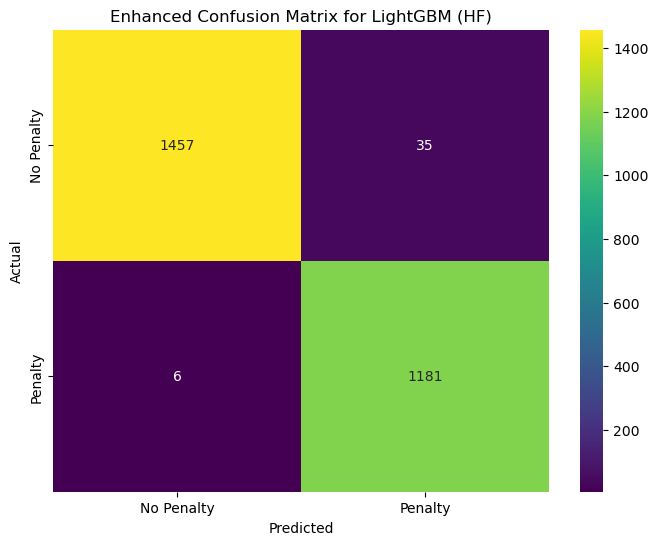

In [ ]:
#try also ['HF', 'pneumonia', 'CABG', 'THA/TKA']
run_enhanced_model_pipeline(df, 'HF')